---

## Import Libraries and source Data

---

In [82]:
options(warn=-1)


library(ggplot2)
library(gridExtra)
library(tidyr)
library(dplyr)
library(caret)
library(corrplot)
library(readr)
library(knitr)
library(kableExtra)
library(formattable)
library(tm)
library(wordcloud)
library(gridExtra)
library(grid)
library(leaflet)
library(randomForest)
options(knitr.table.format = "html") 

In [83]:
df <- suppressMessages(read_csv("simpsons_script_lines.csv"))

In [84]:
#function to make html table more readable

printable <- function(input){
    
    X <- input
    X$text <- sapply(X$text,truncate)
    X$norm_text <- sapply(X$norm_text,truncate)
    X$location <- sapply(X$location,truncate)
    return(X)
    
}

truncate <- function(x){
    if(nchar(x)>25){
        paste(strtrim(x,25),"...")
    }else{
        return(x)
    }
}


---

## Dataframe Exploration

---

What does our dataframe look like?

In [85]:
head(df,n=3)

id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
9549,32,209,"Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",848000,true,464,3,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it,31
9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
9551,32,211,Miss Hoover: I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?,856000,true,464,3,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?,i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you,22


How big is it?

In [86]:
paste('Rows:',as.character(dim(df)[1]))
paste('Cols:',as.character(dim(df)[2]))

[1] "Rows: 157462"

[1] "Cols: 13"

Column types? 

In [87]:
sapply(df, class)

id         episode_id             number           raw_text 
         "integer"          "integer"          "integer"        "character" 
   timestamp_in_ms      speaking_line       character_id        location_id 
         "integer"        "character"          "integer"          "integer" 
raw_character_text  raw_location_text       spoken_words    normalized_text 
       "character"        "character"        "character"        "character" 
        word_count 
       "character"

Let's simplify some column titles,

In [88]:
colnames(df)[9] <- "character"
colnames(df)[10] <- "location"
colnames(df)[11] <- "text"
colnames(df)[12] <- "norm_text"

Get rid of columns we don't need,

In [89]:
df <- subset(df, select = -c(number,raw_text,timestamp_in_ms, speaking_line))

And convert word_count to a numeric type

In [90]:
convert <- function(x){
    if(is.na(as.numeric(x))){
        return(NA)
    }else{
        return(as.numeric(x))
    }
}

df$word_count <- sapply(df$word_count,convert)

Ok now lets recheck the dataframe

In [91]:
printable(head(df,5))

id,episode_id,character_id,location_id,character,location,text,norm_text,word_count
9549,32,464,3,Miss Hoover,Springfield Elementary Sc ...,"No, actually, it was a li ...",no actually it was a litt ...,31
9550,32,9,3,Lisa Simpson,Springfield Elementary Sc ...,Where's Mr. Bergstrom?,wheres mr bergstrom,3
9551,32,464,3,Miss Hoover,Springfield Elementary Sc ...,I don't know. Although I' ...,i dont know although id s ...,22
9552,32,9,3,Lisa Simpson,Springfield Elementary Sc ...,That life is worth living ...,that life is worth living,5
9553,32,40,3,Edna Krabappel-Flanders,Springfield Elementary Sc ...,The polls will be open fr ...,the polls will be open fr ...,33


We may need to do some more work later if we find issues during our analysis, but for now we're done!

---

# Character Line Analysis

---

Lets get a line count for each of the non-null top characters

In [92]:
line_sum <- 

head(
    
    (df %>% 
        filter(character != '') %>% 
        group_by(character) %>% 
        summarise(n=n()) %>% 
        arrange(desc(n))),
    
n=10)



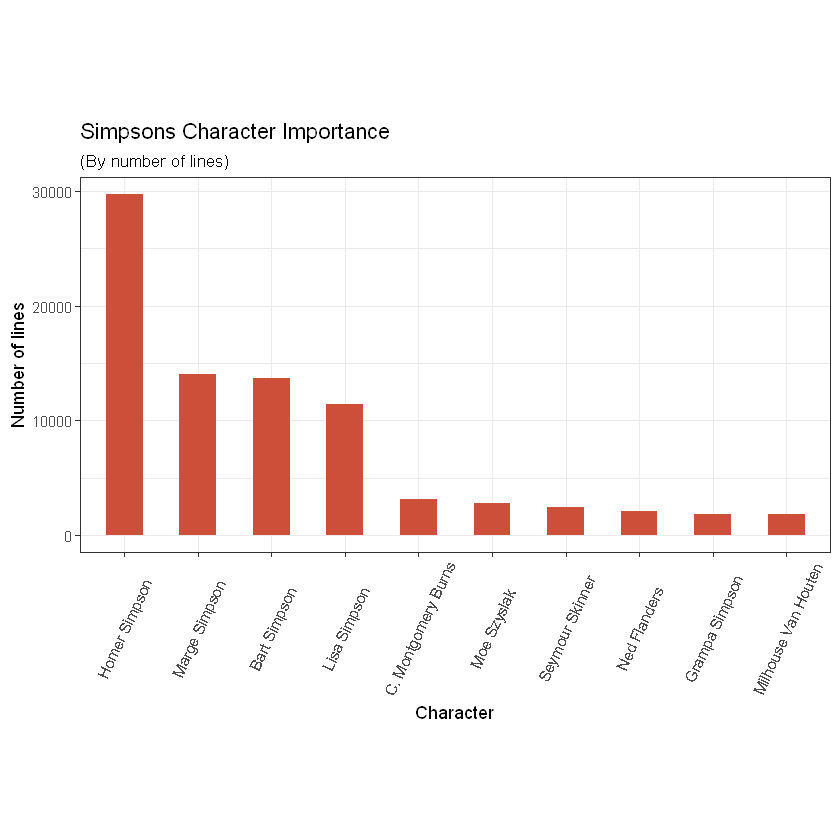

In [93]:
#PLOT

theme_set(theme_bw())

ggplot(data=line_sum, aes(x=reorder(character,-n), y=n)) +

    geom_bar(stat="identity", 
             width=.5, 
             fill="tomato3")+

    labs(x="Character", 
         y="Number of lines", 
         title="Simpsons Character Importance",
         subtitle="(By number of lines)") +

    theme(axis.text.x = element_text(angle=65, vjust=0.5)) +

    theme(aspect.ratio=.5)


We've already seen these results in Gabriela Preda's report,
so instead let's compare line-count with line-length

Our goal is to determine if a character has on average shorter lines, thus affecting their "Importance"

In [94]:
head(
    
    (df %>% 
        filter( character != '') %>% 
        group_by(character) %>%
        summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
        arrange(desc(avg_wordsperline))),
10)

character,avg_wordsperline
Ebenezer Urkel,3340.0000
Neil Gaiman,670.8889
Ted Nugent,639.7500
Actor,209.8667
Greta Wolfcastle,173.0000
Female Host,109.4000
NRBQ,82.0000
SIR MIX-A-LOT,72.0000
Johnny Bobby,69.0000
Jack Black,64.0000


Wow, looks like we might have some false data skewing the results

(I don't remember Ebenezer Urkel's lines well, but I'm sure I would if they were 3 THOUSAND words long)

Let's check out these long character lines:

In [95]:
printable(df %>% filter(word_count>200) %>% arrange(desc(word_count)))

id,episode_id,character_id,location_id,character,location,text,norm_text,word_count
152082,544,NA,4311,NA,"SIX FLAGS OVER KRUSTY"" AM ...",851000,true,6521
138005,492,5932,3975,Neil Gaiman,"TWEEN LIT INC."" MEETING R ...",788000,true,5933
138021,492,NA,3975,NA,TWEEN LIT INC. MEETING RO ...,872000,true,5933
136529,487,NA,3934,NA,"top Chef"" Kitchen,,, 1365 ...",174000,true,5879
136531,487,1,3934,Marge Simpson,"top Chef"" Kitchen,Thank y ...",185000,true,5879
139200,496,2,4018,Homer Simpson,gut Check With Homer Simp ...,1180000,true,5014
139208,496,5014,4018,Ted Nugent,gut Check With Homer Simp ...,1267000,true,5014
96297,334,NA,2804,NA,"HEADBUTT"" SET,,, 96298,33 ...",648000,true,4185
96304,334,2,2804,Homer Simpson,"HEADBUTT"" SET,What'd you ...",694000,true,4185
96306,334,1,2804,Marge Simpson,"HEADBUTT"" SET,I'll have y ...",701000,true,4185


Ah, look at the word counts.  This is all incorrect data, and it explains the high averages for Ebenezer Urkel, Neil Gaiman, Ted Nugent and others, especially since the average is being take over so few lines.

I see a patern: all rows say "true" under normalized_text.   Let's see if my speculation is correct:

In [96]:
printable(df %>% filter(norm_text=="true"))

id,episode_id,character_id,location_id,character,location,text,norm_text,word_count
21349,72,NA,761,NA,"the Lucky Stiff"" Funeral ...",321000,true,990
21353,72,10,761,Patty Bouvier,"the Lucky Stiff"" Funeral ...",513000,true,22
23210,78,2,826,Homer Simpson,Springfield High School C ...,True.,true,1
23212,78,2,826,Homer Simpson,Springfield High School C ...,True.,true,1
50532,179,NA,1663,NA,"MAD"" RECEPTION AREA,,, 50 ...",1004000,true,8
50537,179,8,1663,Bart Simpson,"MAD"" RECEPTION AREA,Oh. O ...",1054000,true,2290
66294,232,NA,2002,NA,SPRINGFIELD SQUARES GAMES ...,617000,true,33
66298,232,1867,2002,Disco Stu,SPRINGFIELD SQUARES GAMES ...,640000,true,211
66300,232,1867,2002,Disco Stu,"SPRINGFIELD SQUARES"" GAME ...",646000,true,211
66311,232,2,2002,Homer Simpson,"SPRINGFIELD SQUARES"" GAME ...",677000,true,2580


Yep, all false data.  If we dump all of it, how much damage are we doing?

In [97]:
x <- dim(df %>% filter(norm_text=='true'))[1]

print(paste("Rows:",as.character(x)))

y <- round((100*(x/157462)),2)

print(paste("Percentage of df:",as.character(y),"%"))


[1] "Rows: 64"
[1] "Percentage of df: 0.04 %"


*Laaaaaaater*

![title](https://assets-cdn.github.com/images/icons/emoji/unicode/270c.png)

In [98]:
df <- df %>% filter(norm_text !='true')

In [99]:
printable(head(df %>% arrange(desc(word_count)),10))

id,episode_id,character_id,location_id,character,location,text,norm_text,word_count
22701,76,31,51,Grampa Simpson,Burns's Office,One trick is to tell them ...,one trick is to tell them ...,122
134211,478,5807,3869,Randy Newman,BEVERLY HILTON-TYPE HOTEL,It was not! Who else in h ...,it was not who else in he ...,116
3069,10,2,171,Homer Simpson,Sapphire Lounge,Quiet! I have something t ...,quiet i have something to ...,114
52015,184,2,583,Homer Simpson,Police Car,"Scully, you're cut. Ehhh, ...",scully youre cut ehhh bro ...,111
99981,347,4349,2906,David Silverman,FISHING WHARF,"David Silverman here, Sup ...",david silverman here supe ...,111
156167,560,6685,4417,SAMMY HAGAR,SPRINGFIELD POLICE DEPART ...,"So there I am, in Easter ...",so there i am in easter i ...,110
27895,94,1337,136,James Woods,Kwik-E-Mart,"To-Toni, Toni, do-- you'r ...",to-toni toni do-- youre m ...,106
28412,96,211,1014,Kent Brockman,SIMPSONS' BASE HOUSING LI ...,"Ladies and gentlemen, we' ...",ladies and gentlemen weve ...,106
135363,482,5846,3910,Ewell Freestone,SPRINGFIELD MAGIC PALACE,AND THE YEAR'S FOURTH PEA ...,and the years fourth peac ...,105
15882,52,276,572,Singers,SOFTBALL DIAMOND,WELL MR. BURNS HAD DONE I ...,well mr burns had done it ...,103


This looks SO much better.  We're ready to look at some averages!

In [100]:
head(
    
    (df %>% 
        filter( character != '') %>% 
        group_by(character) %>%
        summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
        arrange(desc(avg_wordsperline))),
10)

character,avg_wordsperline
NRBQ,82.00
SIR MIX-A-LOT,72.00
Johnny Bobby,69.00
Jack Black,64.00
David Silverman,61.00
Randy Jackson,59.00
Ellen DeGeneres,58.00
Randy Newman,57.75
SAMMY HAGAR,52.00
TRUONG,52.00


It makes sense that celebrities characters have the longest lines.  Writer's probably to squeeze the most dialog out of their short cameos

Now back to the *original question*: what does this mean for our main characters?

In [101]:
line_counts <- 

head(
    
    (df %>% 
        filter((character != '') & (word_count!= '')) %>% 
        group_by(character) %>% 
        summarise(total_words = sum(word_count)) %>% 
        arrange(desc(total_words))),
 
 n=10)

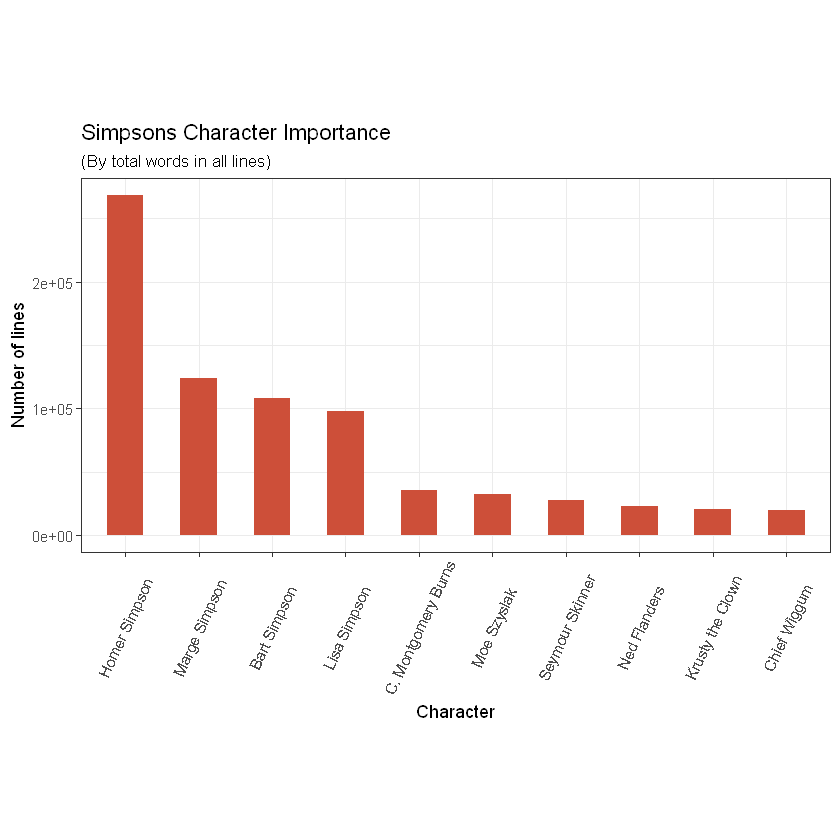

In [102]:
theme_set(theme_bw())

ggplot(data=line_counts, aes(x=reorder(character,-total_words), y=total_words)) +

    geom_bar(stat="identity", 
             width=.5, 
             fill="tomato3")+

    labs(x="Character", 
         y="Number of lines", 
         title="Simpsons Character Importance",
         subtitle="(By total words in all lines)") +

    theme(axis.text.x = element_text(angle=65, vjust=0.5)) +

    theme(aspect.ratio=.5)

Doesn't change much for our top 8 characters, however we have an appearance of 2 new characters: *Krusty* and *Chief Wiggum*.  Maybe they have longer lines than the characters they replaced (Grandpa and Millhouse)

In [103]:
df %>% 
    filter( character == "Krusty the Clown"| 
           character == "Chief Wiggum" | 
           character == "Grampa Simpson" | 
           character == 'Milhouse Van Houten' ) %>% 
    group_by(character) %>%
    summarise(avg_wordsperline=mean(word_count, na.rm = TRUE )) %>%
    arrange(desc(avg_wordsperline))


character,avg_wordsperline
Krusty the Clown,12.146154
Chief Wiggum,11.162192
Grampa Simpson,10.801111
Milhouse Van Houten,8.285879


We we're right!  Although you would think the longest line in the whole show belonging to Grampa would help is average a little more.

https://www.youtube.com/watch?v=5Rzao52ndNA

This makes me wonder about Grandpa's distribution vs the other's

In [104]:
plot1 <- df %>% filter( character == "Grampa Simpson" & word_count != '' & id != 22701 ) #rid of longest line
plot2 <- df %>% filter( character == "Krusty the Clown" & word_count != '')
plot3 <- df %>% filter( character == "Milhouse Van Houten" & word_count != '')
plot4 <- df %>% filter( character == "Chief Wiggum" & word_count != '')

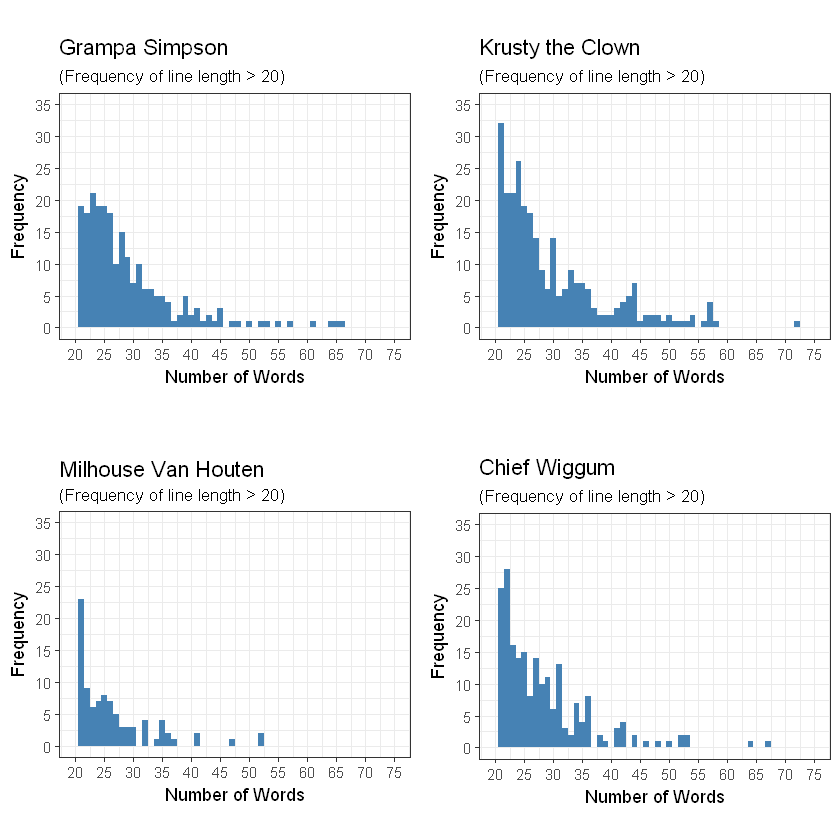

In [105]:
require(gridExtra)

theme_set(theme_bw())

p1 <- ggplot(data=plot1, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Grampa Simpson",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p2 <- ggplot(data=plot2, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Krusty the Clown",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p3 <- ggplot(data=plot3, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Milhouse Van Houten",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

p4 <- ggplot(data=plot4, aes(x=word_count))+
    geom_histogram(binwidth=1, fill="steelblue")+
    labs(x="Number of Words", 
         y="Frequency", 
         title="Chief Wiggum",
         subtitle="(Frequency of line length > 20)") +
    scale_y_continuous(limits=c(0,35),
                       breaks=(5*(0:7)))+
    scale_x_continuous(limits=c(20,75),
                       breaks=(5*(4:15)))+
    theme(aspect.ratio=.7)

grid.arrange(p1,p2,p3,p4)